# Train 

you can jump the train if only want to use the model.

In [6]:
from __future__ import print_function, division
import os
import numpy as np
from PIL import Image
import glob

from torch import optim
import torch.utils.data
import torch
import torch.nn.functional as F

import torch.nn
import torchvision
import matplotlib.pyplot as plt
import natsort
from torch.utils.data.sampler import SubsetRandomSampler
from Data_Loader import Images_Dataset, Images_Dataset_folder
import torchsummary

import shutil
import random
from Models import Unet_dict, NestedUNet, U_Net, R2U_Net, AttU_Net, R2AttU_Net
from losses import calc_loss, dice_loss, threshold_predictions_v,threshold_predictions_p
from ploting import plot_kernels, LayerActivations, input_images, plot_grad_flow
from Metrics import dice_coeff, accuracy_score
import time

#######################################################
#Checking if GPU is used
#######################################################

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

device = torch.device("cuda:0" if train_on_gpu else "cpu")

#######################################################
#Setting the basic paramters of the model
#######################################################

batch_size = 4
print('batch_size = ' + str(batch_size))

valid_size = 0.15

epoch = 25
print('epoch = ' + str(epoch))

random_seed = random.randint(1, 100)
print('random_seed = ' + str(random_seed))

shuffle = True
valid_loss_min = np.Inf
num_workers = 4
lossT = []
lossL = []
lossL.append(np.inf)
lossT.append(np.inf)
epoch_valid = epoch-2
n_iter = 1
i_valid = 0

pin_memory = False
if train_on_gpu:
    pin_memory = True

#######################################################
#Setting up the model
#######################################################

model_Inputs = [U_Net, R2U_Net, AttU_Net, R2AttU_Net, NestedUNet]


def model_unet(model_input, in_channel=3, out_channel=1):
    model_test = model_input(in_channel, out_channel)
    return model_test

#passsing this string so that if it's AttU_Net or R2ATTU_Net it doesn't throw an error at torchSummary
model_test = model_unet(model_Inputs[0], 3, 1)
model_test.to(device)

#######################################################
#Getting the Summary of Model
#######################################################

torchsummary.summary(model_test, input_size=(3, 128, 128))

#######################################################
#Passing the Dataset of Images and Labels
#######################################################

t_data = './ISIC/ISIC2018_Task1-2_Training_Input_x2/'
l_data = './ISIC/ISIC2018_Task1_Training_GroundTruth_x2/'
test_image = './ISIC/ISIC2018_Task1-2_Training_Input_x2/ISIC_0000999.jpg'
test_label = './ISIC/ISIC2018_Task1_Training_GroundTruth_x2/ISIC_0000999_segmentation.png'
test_folderP = './ISIC-copy/ISIC2018_Task1-2_Training_Input_x2/'
test_folderL = './ISIC-copy/ISIC2018_Task1_Training_GroundTruth_x2/'


#######################################################
#Giving a transformation for input data
#######################################################

data_transform = torchvision.transforms.Compose([
           torchvision.transforms.Resize((128, 128)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

data_transform2 = torchvision.transforms.Compose([
           torchvision.transforms.Resize((128, 128)),
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
        ])

Training_Data = Images_Dataset_folder(t_data, l_data, data_transform, data_transform2)

#######################################################
#Trainging Validation Split
#######################################################

num_train = len(Training_Data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(Training_Data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory,)

valid_loader = torch.utils.data.DataLoader(Training_Data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers, pin_memory=pin_memory,)

#######################################################
#Using Adam as Optimizer
#######################################################

initial_lr = 0.001
opt = torch.optim.Adam(model_test.parameters(), lr=initial_lr) # try SGD
#opt = optim.SGD(model_test.parameters(), lr = initial_lr, momentum=0.99)

MAX_STEP = int(1e10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, MAX_STEP, eta_min=1e-5)

#######################################################
#Creating a Folder for every data of the program
#######################################################

New_folder = './model'

if os.path.exists(New_folder) and os.path.isdir(New_folder):
    shutil.rmtree(New_folder)

try:
    os.mkdir(New_folder)
except OSError:
    print("Creation of the main directory '%s' failed " % New_folder)
else:
    print("Successfully created the main directory '%s' " % New_folder)

#######################################################
#Setting the folder of saving the predictions
#######################################################

read_pred = './model/pred'

#######################################################
#Checking if prediction folder exixts
#######################################################

if os.path.exists(read_pred) and os.path.isdir(read_pred):
    shutil.rmtree(read_pred)

try:
    os.mkdir(read_pred)
except OSError:
    print("Creation of the prediction directory '%s' failed of dice loss" % read_pred)
else:
    print("Successfully created the prediction directory '%s' of dice loss" % read_pred)

#######################################################
#checking if the model exists and if true then delete
#######################################################

read_model_path = './model/Unet_D_' + str(epoch) + '_' + str(batch_size)

if os.path.exists(read_model_path) and os.path.isdir(read_model_path):
    shutil.rmtree(read_model_path)
    print('Model folder there, so deleted for newer one')

try:
    os.mkdir(read_model_path)
except OSError:
    print("Creation of the model directory '%s' failed" % read_model_path)
else:
    print("Successfully created the model directory '%s' " % read_model_path)

CUDA is available. Training on GPU
batch_size = 4
epoch = 25
random_seed = 6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        conv_block-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13      

In [7]:
data_transform3 = torchvision.transforms.Compose([
           torchvision.transforms.Resize((128, 128)),
        ])
data_transform4 = torchvision.transforms.Compose([
           torchvision.transforms.Resize((128, 128)),
         #   torchvision.transforms.CenterCrop(96),
            torchvision.transforms.Grayscale(),
        ])

x_sort_testP = sorted(os.listdir(test_folderP))
x_sort_testP = [test_folderP + i for i in sorted(os.listdir(test_folderP))]

x_sort_testL = sorted(os.listdir(test_folderL))
x_sort_testL = [test_folderL + i for i in sorted(os.listdir(test_folderL))]

x_sort_test = [test_folderP + i for i in sorted(os.listdir(test_folderP))]

In [8]:
#######################################################
#Training loop
#######################################################

model_train_loss = []
model_valid_loss = []
model_test_dice = []
model_test_iou = []
for i in range(epoch):

    train_loss = 0.0
    valid_loss = 0.0
    since = time.time()
    scheduler.step(i)
    lr = scheduler.get_lr()

    #######################################################
    #Training Data
    #######################################################

    model_test.train()
    k = 1

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        #If want to get the input images with their Augmentation - To check the data flowing in net
        input_images(x, y, i, n_iter, k)

        opt.zero_grad()
        y_pred = model_test(x)
        lossT = calc_loss(y_pred, y) # Dice_loss Used

        train_loss += lossT.item() * x.size(0)
        lossT.backward()
        opt.step()
        x_size = lossT.item() * x.size(0)
        k = 2

    #######################################################
    #Validation Step
    #######################################################

    model_test.eval()
    torch.no_grad() # to increase the validation process uses less memory

    for x1, y1 in valid_loader:
        x1, y1 = x1.to(device), y1.to(device)

        y_pred1 = model_test(x1)
        lossL = calc_loss(y_pred1, y1) # Dice_loss Used

        valid_loss += lossL.item() * x1.size(0)
        x_size1 = lossL.item() * x1.size(0)

    #######################################################
    #Saving the predictions
    #######################################################

    im_tb = Image.open(test_image)
    im_label = Image.open(test_label)
    s_tb = data_transform(im_tb)
    s_label = data_transform2(im_label)
    s_label = s_label.detach().numpy()

    pred_tb = model_test(s_tb.unsqueeze(0).to(device)).cpu()
    pred_tb = F.sigmoid(pred_tb)
    pred_tb = pred_tb.detach().numpy()

    x1 = plt.imsave(
        './model/pred/img_iteration_' + str(n_iter) + '_epoch_'
        + str(i) + '.png', pred_tb[0][0])
    
    #######################################################
    #To write in Tensorboard
    #######################################################

    train_loss = train_loss / len(train_idx)
    valid_loss = valid_loss / len(valid_idx)
    
    model_train_loss.append(train_loss)
    model_valid_loss.append(valid_loss)

    if (i+1) % 1 == 0:
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(i + 1, epoch, train_loss,
                                                                                      valid_loss))

    #######################################################
    #Early Stopping
    #######################################################

    if valid_loss <= valid_loss_min and epoch_valid >= i: # and i_valid <= 2:

        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model '.format(valid_loss_min, valid_loss))
        torch.save(model_test.state_dict(),'./model/Unet_D_' +
                                              str(epoch) + '_' + str(batch_size) + '/Unet_epoch_' + str(epoch)
                                              + '_batchsize_' + str(batch_size) + '.pth')
        
        if round(valid_loss, 4) == round(valid_loss_min, 4):
            print(i_valid)
            i_valid = i_valid+1
        valid_loss_min = valid_loss

    #######################################################
    # Extracting the intermediate layers
    #######################################################

    #####################################
    # for kernals
    #####################################
    x1 = torch.nn.ModuleList(model_test.children())

    #####################################
    # for images
    #####################################
    x2 = len(x1)
    dr = LayerActivations(x1[x2-1]) # Getting the last Conv Layer

    img = Image.open(test_image)
    s_tb = data_transform(img)

    pred_tb = model_test(s_tb.unsqueeze(0).to(device)).cpu()
    pred_tb = F.sigmoid(pred_tb)
    pred_tb = pred_tb.detach().numpy()

    plot_kernels(dr.features, n_iter, 7, cmap="rainbow")

    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

    im = Image.open(x_sort_test[0])

    im1 = im
    im_n = np.array(im1)
    im_n_flat = im_n.reshape(-1, 1)

    for j in range(im_n_flat.shape[0]):
        if im_n_flat[j] != 0:
            im_n_flat[j] = 255

    s = data_transform(im)
    pred = model_test(s.unsqueeze(0).cuda()).cpu()
    pred = F.sigmoid(pred)
    pred = pred.detach().numpy()
    
    it = Image.open(x_sort_testL[0])
    A = np.array(data_transform4(it))//255
    B = pred[0][0]
    
    intersection = (A * B).sum()
    union = A.sum() + B.sum() - intersection
    iou = intersection / union
    model_test_iou.append(iou)
    dice = 2/(1/iou + 1)
    model_test_dice.append(dice)
    print(dice, iou)
    
    n_iter += 1

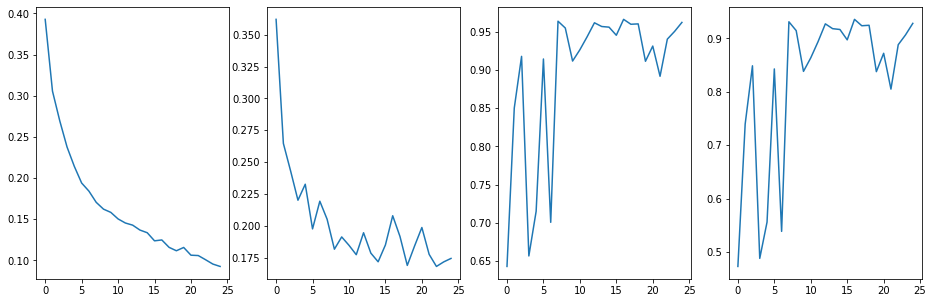

In [12]:
#######################################################
# Ploting the comparision plot - 
#######################################################
plt.figure(figsize=(20, 5))
plt.subplot(1,5,1) 
plt.plot(model_train_loss)
plt.subplot(1,5,2) 
plt.plot(model_valid_loss)
plt.subplot(1,5,3) 
plt.plot(model_test_dice)
plt.subplot(1,5,4) 
plt.plot(model_test_iou)


# test

In [1]:
from __future__ import print_function, division
import os
import numpy as np
from PIL import Image

import torch.nn.functional as F

import torch.nn
import torchvision
import matplotlib.pyplot as plt

import torchsummary


import shutil
import random
from Models import Unet_dict, NestedUNet, U_Net, R2U_Net, AttU_Net, R2AttU_Net
from losses import calc_loss, dice_loss, threshold_predictions_v,threshold_predictions_p
from Metrics import dice_coeff, accuracy_score
import time

#######################################################
#Checking if GPU is used
#######################################################

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

device = torch.device("cuda:0" if train_on_gpu else "cpu")

#######################################################
#Setting the basic paramters of the model
#######################################################

batch_size = 4
print('batch_size = ' + str(batch_size))

valid_size = 0.15

epoch = 15
print('epoch = ' + str(epoch))

random_seed = random.randint(1, 100)
print('random_seed = ' + str(random_seed))

shuffle = True
valid_loss_min = np.Inf
num_workers = 4
lossT = []
lossL = []
lossL.append(np.inf)
lossT.append(np.inf)
epoch_valid = epoch-2
n_iter = 1
i_valid = 0

pin_memory = False
if train_on_gpu:
    pin_memory = True


#######################################################
#Setting up the model
#######################################################

model_Inputs = [U_Net, R2U_Net, AttU_Net, R2AttU_Net, NestedUNet]


def model_unet(model_input, in_channel=3, out_channel=1):
    model_test = model_input(in_channel, out_channel)
    return model_test

#passsing this string so that if it's AttU_Net or R2ATTU_Net it doesn't throw an error at torchSummary


model_test = model_unet(model_Inputs[0], 3, 1)

model_test.to(device)

#######################################################
#Getting the Summary of Model
#######################################################

torchsummary.summary(model_test, input_size=(3, 128, 128))

#######################################################
#Passing the Dataset of Images and Labels
#######################################################


test_folderP = './ISIC-copy/ISIC2018_Task1-2_Training_Input_x2/'
test_folderL = './ISIC-copy/ISIC2018_Task1_Training_GroundTruth_x2/'

#######################################################
#Giving a transformation for input data
#######################################################

data_transform = torchvision.transforms.Compose([
           torchvision.transforms.Resize((128, 128)),
         #   torchvision.transforms.CenterCrop(96),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

data_transform2 = torchvision.transforms.Compose([
           torchvision.transforms.Resize((128, 128)),
         #   torchvision.transforms.CenterCrop(96),
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
        ])

#######################################################
#checking if cuda is available
#######################################################

if torch.cuda.is_available():
    torch.cuda.empty_cache()

#######################################################
#Loading the model
#######################################################

model_test.load_state_dict(torch.load('./model/Unet_D_10_4/Unet_epoch_10_batchsize_4.pth'))

model_test.eval()

#######################################################
#opening the test folder and creating a folder for generated images
#######################################################

x_sort_test = [test_folderP + i for i in sorted(os.listdir(test_folderP))]

read_test_folder112 = './model/gen_images'


if os.path.exists(read_test_folder112) and os.path.isdir(read_test_folder112):
    shutil.rmtree(read_test_folder112)

try:
    os.mkdir(read_test_folder112)
except OSError:
    print("Creation of the testing directory %s failed" % read_test_folder112)
else:
    print("Successfully created the testing directory %s " % read_test_folder112)


# For Prediction Threshold

read_test_folder_P_Thres = './model/pred_threshold'


if os.path.exists(read_test_folder_P_Thres) and os.path.isdir(read_test_folder_P_Thres):
    shutil.rmtree(read_test_folder_P_Thres)

try:
    os.mkdir(read_test_folder_P_Thres)
except OSError:
    print("Creation of the testing directory %s failed" % read_test_folder_P_Thres)
else:
    print("Successfully created the testing directory %s " % read_test_folder_P_Thres)

# For Label Threshold

read_test_folder_L_Thres = './model/label_threshold'


if os.path.exists(read_test_folder_L_Thres) and os.path.isdir(read_test_folder_L_Thres):
    shutil.rmtree(read_test_folder_L_Thres)

try:
    os.mkdir(read_test_folder_L_Thres)
except OSError:
    print("Creation of the testing directory %s failed" % read_test_folder_L_Thres)
else:
    print("Successfully created the testing directory %s " % read_test_folder_L_Thres)

CUDA is available. Training on GPU
batch_size = 4
epoch = 15
random_seed = 56
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        conv_block-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13     

## test image 0

In [11]:
ind = 0

im = Image.open(x_sort_test[ind])

im1 = im
im_n = np.array(im1)
im_n_flat = im_n.reshape(-1, 1)

for j in range(im_n_flat.shape[0]):
    if im_n_flat[j] != 0:
        im_n_flat[j] = 255

s = data_transform(im)
pred = model_test(s.unsqueeze(0).cuda()).cpu()
pred = F.sigmoid(pred)
pred = pred.detach().numpy()

pred = threshold_predictions_p(pred)

it = Image.open(x_sort_testL[ind])

(384, 511, 3)


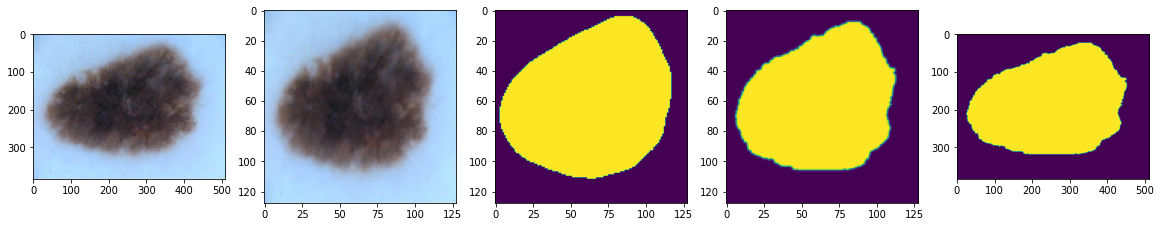

In [80]:
source = np.array(im)
print(source.shape)
plt.figure(figsize=(20, 5))
plt.subplot(1,5,1) 
plt.imshow(source)
plt.subplot(1,5,2) 
plt.imshow(data_transform3(im))
plt.subplot(1,5,3) 
plt.imshow(pred[0][0])
plt.subplot(1,5,4) 
plt.imshow(data_transform4(it))
plt.subplot(1,5,5) 
plt.imshow(it)

upper image: previous image -> resize -> generated -> target -> real target

compute iou:

In [12]:
A = np.array(data_transform4(it))//255
B = pred[0][0]
intersection = (A * B).sum()
union = A.sum() + B.sum() - intersection
IOU = intersection / union
IOU

0.8461005199306759

In [13]:
dice = 2/(1/IOU + 1)
dice

0.9166353736387535

# compute avarage IOU & DICE

In [11]:
ious = []

dices = []

for i in range(len(x_sort_test)):
    im = Image.open(x_sort_test[i])

    im1 = im
    im_n = np.array(im1)
    im_n_flat = im_n.reshape(-1, 1)

    for j in range(im_n_flat.shape[0]):
        if im_n_flat[j] != 0:
            im_n_flat[j] = 255

    s = data_transform(im)
    pred = model_test(s.unsqueeze(0).cuda()).cpu()
    pred = F.sigmoid(pred)
    pred = pred.detach().numpy()
    
    it = Image.open(x_sort_testL[i])
    A = np.array(data_transform4(it))//255
    B = pred[0][0]
    
    intersection = (A * B).sum()
    union = A.sum() + B.sum() - intersection
    iou = intersection / union
    ious.append(iou)
    dice = 2/(1/iou + 1)
    dices.append(dice)
    
    
    
print("average IOU", sum(ious)/len(ious))
print("average DICE", sum(dices)/len(dices))

average IOU 0.8429712252142243
average DICE 0.9121954261505673
